# Setup

In [1]:
import numpy as np
import scipy.signal

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="3"

# Generate Data

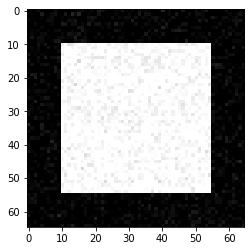

In [2]:
input = np.zeros((65, 65))
input[2, 5] = 0.4
input[12, 17] = 0.7

a,b= np.meshgrid(np.linspace(-1, 1, 65), np.linspace(-1, 1, 65))
Img = np.array(np.logical_and(np.abs(a) < 0.7, np.abs(b) < 0.7),dtype='float32') 

IMG_T=torch.FloatTensor(Img)
IMG_T.shape
IMG_T2 = torch.unsqueeze(IMG_T, dim=0)
IMG_T2.shape
noisyImg = np.clip(Img + np.random.normal(scale=0.05, size=IMG_T2.shape), 0, 1).astype(np.float32) # adding noise from normal distribution
noisyImg_T=torch.FloatTensor(noisyImg)
noisyImg_T.shape
plt.imshow(noisyImg_T[0], cmap='gray')
clean=IMG_T2.unsqueeze(0)
noisy=noisyImg_T.unsqueeze(0)


In [3]:
clean.shape

torch.Size([1, 1, 65, 65])

In [4]:
noisy.shape

torch.Size([1, 1, 65, 65])

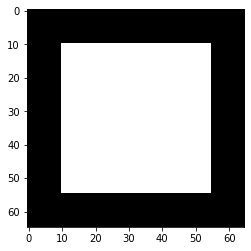

In [7]:
plt.imshow(clean[0][0], cmap='gray')

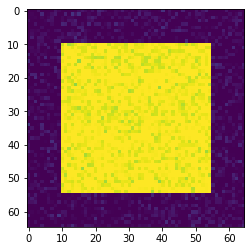

In [6]:
plt.imshow(noisy[0][0])

In [7]:
torch.max(noisy)

tensor(1.)

In [8]:
class Anet(nn.Module):
    def __init__(self, channel=8):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(1, self.channel, kernel_size=(65,1),padding=(32,0), padding_mode='circular', bias=False, groups=1) #circular
        self.conv2 = nn.Conv2d(self.channel, 1, kernel_size=(1,65),padding=(0,32), padding_mode='circular',bias=False, groups=1)
        #groups
    def forward(self, x):
        #x1 =self.conv1(x)
        x1 =F.relu(self.conv1(x))
        out =F.relu(self.conv2(x1))
        #out = self.conv2(x1)
        #U = self.conv1.weight.detach().clone()
        #V = self.conv2.weight.detach().clone()
        return out
A_net = Anet() #.to(device)
mse = nn.MSELoss()
x = torch.randn(1, 1, 65, 65)
A_net(x).shape

torch.Size([1, 1, 65, 65])

In [9]:
from zmq import device
## reshape the tensors to a matrix

## inner dim =2
[8, 1, 65, 1]
[1,8, 1, 65]



def my_outer(U, V):
  UV=torch.outer(U[0,0,:,0], V[0,0,0,:])
  for i in range(1, U.shape[0]):
    UV=UV+torch.outer(U[i,0,:,0], V[0,i,0,:])
  return UV

## getting singular values

def my_singular(U, V):
  UV=my_outer(U, V)
  return np.array(torch.linalg.svdvals(UV).to('cpu').detach())
   
  

 #def my_svd(U,V):
    #UV=my_outer(U, V)
    #A,S,B= np.array(torch.svd_lowrank(UV, q=8, niter=2, M=None).to('cpu').detach())
    #return A,S,B



def Nuc_norm(U,V):
    sigma_vec= my_singular(U, V)
    return np.sum(sigma_vec)


In [10]:
def plot_epoch(recon_np,noisyImg1, Img):
  #if i % 50 == 0:
    fig = plt.figure(figsize=(7, 7))
    rows = 2
    columns = 2
    plt.subplot(rows, columns, 1)
    #recon_np = recon.squeeze(0).permute(1, 2, 0).to('cpu').detach().numpy()
    plt.imshow(recon_np, cmap='gray')
    plt.axis('off')
    plt.title("recon")
    plt.subplot(rows, columns, 2)
    plt.imshow(Img, cmap='gray')
    plt.axis('off')
    plt.title("Img")
    plt.subplot(rows, columns, 3)
    plt.imshow(noisyImg1, cmap='gray')
    plt.axis('off')
    plt.title("Img+Noise")
    plt.show()
    plt.show()

> ### Training Function








In [11]:
def recon(noisy, clean, alpha=0., iterations=100000, lr=1.e-2, gpu=True):
  import time

  cuda = torch.device('cuda') 

  A_net = Anet()
  x = torch.randn(1, 1, 65, 65)

  if gpu:
    A_net = A_net.to(cuda)
    x = x.to(cuda)
    noisy = noisy.to(cuda)
    clean = clean.to(cuda)

    #U=U.to(cuda)
    #V=V.to(cuda)
  
  optimizer = optim.SGD(A_net.parameters(), lr=lr)

  Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = [],[], [], [], [],[], [], [], [], [],[]

  start = time.time()
  for i in tqdm(range(iterations)):

    recon = A_net(x)
    
    l2_norm = sum(p.pow(2.0).sum() for p in A_net.parameters()) #L2 norm of weights (p**2)
    U, V=[ p for p in A_net.parameters()]  ## get the kernels

    loss_recon = mse(recon, noisy)
    Loss_Rec.append(loss_recon.item())
    
    loss_regu = alpha * l2_norm
    Loss_Reg.append(loss_regu.item())

    loss = loss_recon + loss_regu
    Loss.append(loss.item())

    error = mse(recon, clean)
    Error.append(error.item())
    
    #SVD.append(my_svd(U,V))
    S_values.append(my_singular(U, V))
    UV_outer.append(my_outer(U, V))
    Recons.append(recon)
    U_kernel.append(U)
    V_kernel.append(V)
    
    norm2.append(l2_norm)
    Nuc.append(Nuc_norm(U,V))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if i % 10000 == 0:
      plot_epoch(recon[0].squeeze(0).permute(1, 0).to('cpu').detach().numpy(), noisyImg_T[0], Img)
  end = time.time()
  print(f"ending time in: {((end-start)/60):.3f} mins")
  

  return Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 

# Reco for different Alpha

In [12]:
from numpy.ma.core import outer
Loss_Rec, Loss_Reg, Loss, Error, Sigma, OutP, Rec, kerU, kerV, Norm1, Norm2 = [], [], [], [], [],[], [], [], [], [],[]

#Adapot alpha here!!!!
Alpha = np.linspace(0,0.01,3)

for alpha in Alpha:

  print(alpha)
  # lr 1.e-1 is too large ?
  # ->need more iterations ~ maybe 100000 are too many? 
  loss_rec, loss_reg, loss, error, s, outer, recs, u_ker, v_ker,nuc_norm, norm_2 = recon(noisy, clean, gpu=True , alpha=alpha, iterations=100000)

  Loss_Rec.append(loss_rec)
  Loss_Reg.append(loss_reg)
  Loss.append(loss)
  Error.append(error)
  Sigma.append(s)
  OutP.append(outer)
  Rec.append(recs)
  kerU.append(u_ker)
  kerV.append(v_ker)
  Norm1.append(nuc_norm)
  Norm2.append(norm_2)  


Loss_Rec2=np.array(Loss_Rec)
Loss_Reg2=np.array(Loss_Reg)
Loss2=np.array(Loss)
Error2=np.array(Error)
Sigma_arr2=np.array(Sigma)
OutP_arr2= np.array(OutP)
Rec_arr2= np.array(Rec)
kerU_arr2= np.array(kerU)
kerV_arr2= np.array(kerV)
Norm1_arr2= np.array(Norm1)
Norm2_arr2= np.array(Norm2)

0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

ending time in: 11.818 mins
0.005


  0%|          | 0/100000 [00:00<?, ?it/s]

ending time in: 12.227 mins
0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 31.75 GiB total capacity; 6.63 GiB already allocated; 4.00 MiB free; 6.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import sys
#sys.path.insert(0,'/content/drive/My Drive/data/')

Mounted at /content/drive


In [62]:
#save files
np.save("/home/sbazoobandi/data/Loss_Rec.npy", Loss_Rec2) 
np.save("/home/sbazoobandi/data/Loss_Reg.npy", Loss_Reg2)
np.save("/home/sbazoobandi/data/Loss.npy",Loss2)
np.save("/home/sbazoobandi/data/Error.npy", Error2)
np.save("/home/sbazoobandi/data/Alpha.npy", Alpha)
np.save("/home/sbazoobandi/data/Sigma.npy", Sigma_arr2)
np.save("/home/sbazoobandi/data/OutP_arr.npy", OutP_arr2)
np.save("/home/sbazoobandi/data/Rec_arr.npy", Rec_arr2)
np.save("/home/sbazoobandi/data/kerU_arr.npy", kerU_arr2)
np.save("/home/sbazoobandi/data/kerV_arr.npy", kerV_arr2)
np.save("/home/sbazoobandi/data/Norm1_arr.npy", Norm1_arr2)

# Load files and Plotting

In [ ]:
Loss_Rec=np.load("/home/sbazoobandi/data/Loss_Rec.npy", Loss_Rec2) 
Loss_Reg=np.load("/home/sbazoobandi/data/Loss_Reg.npy", Loss_Reg2)
Loss=np.load("/home/sbazoobandi/data/Loss.npy",Loss2)
Error=np.load("/home/sbazoobandi/data/Error.npy", Error2)
Alpha=np.load("/home/sbazoobandi/data/Alpha.npy", Alpha)
Sigma_arr=np.load("/home/sbazoobandi/data/Sigma.npy", Sigma_arr2)
OutP_arr=np.load("/home/sbazoobandi/data/OutP_arr.npy", OutP_arr2)
Rec_arr=np.load("/home/sbazoobandi/data/Rec_arr.npy", Rec_arr2)
kerU_arr=np.load("/home/sbazoobandi/data/kerU_arr.npy", kerU_arr2)
kerV_arr=np.load("/home/sbazoobandi/data/kerV_arr.npy", kerV_arr2)
Norm1_arr=np.load("/home/sbazoobandi/data/Norm1_arr.npy", Norm1_arr2)

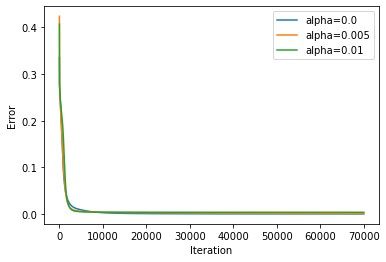

In [64]:
for i in range(Alpha.shape[0]):
  plt.plot(Error2[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Error")

plt.legend()
plt.show()

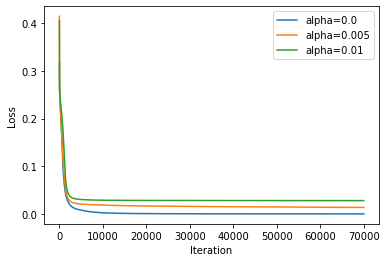

In [65]:
for i in range(Alpha.shape[0]):
  plt.plot(Loss2[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.legend()
plt.show()


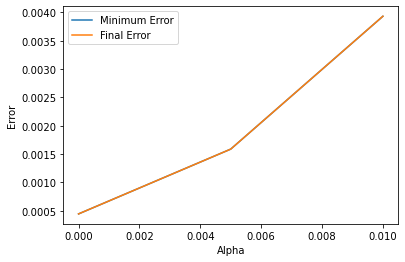

In [66]:
plt.plot(Alpha, np.min(Error2, axis=1), label="Minimum Error")
plt.plot(Alpha, Error2[:,-1], label="Final Error")

plt.xlabel("Alpha")
plt.ylabel("Error")

plt.legend()
plt.show()


  0%|          | 0/100000 [00:00<?, ?it/s]

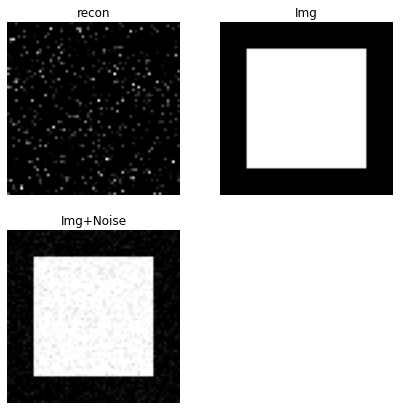

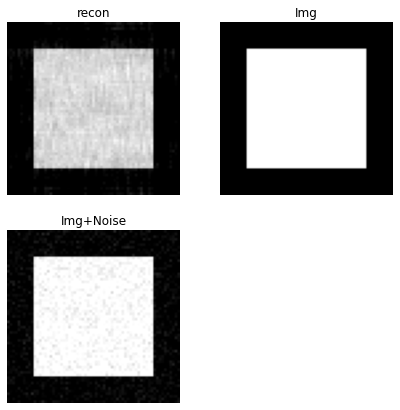

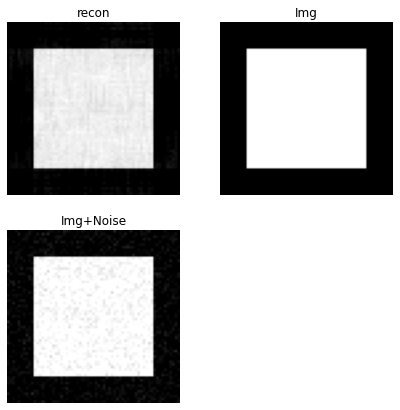

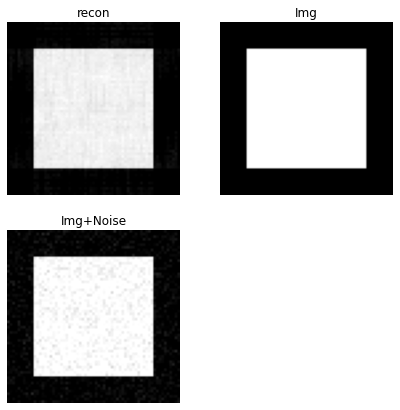

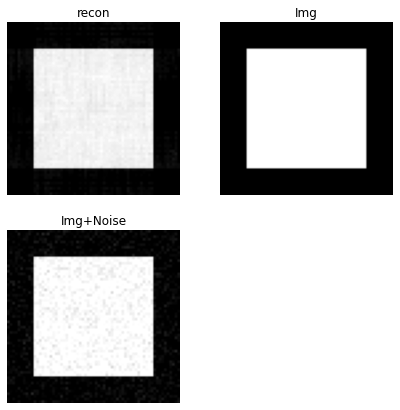

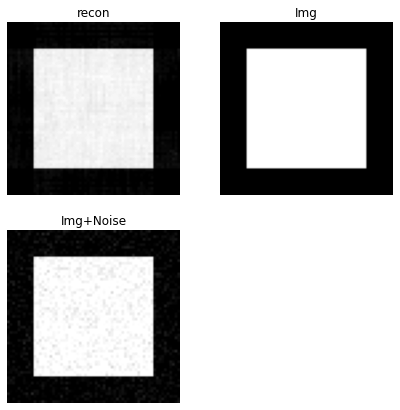

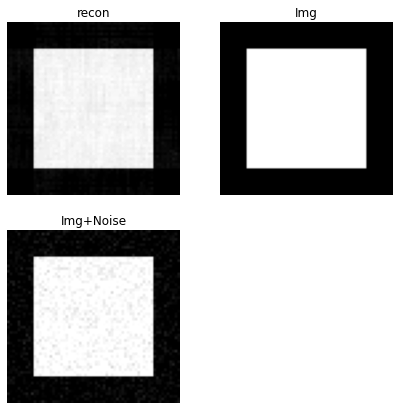

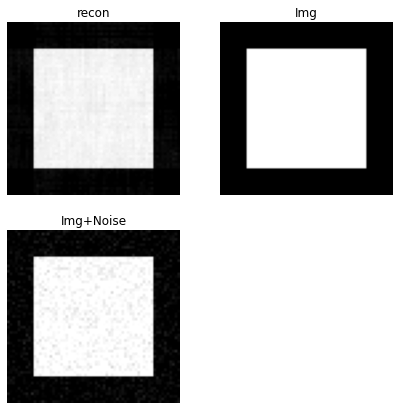

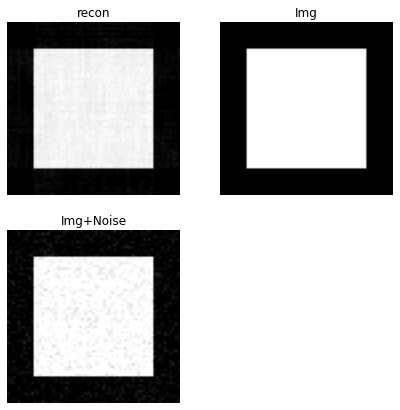

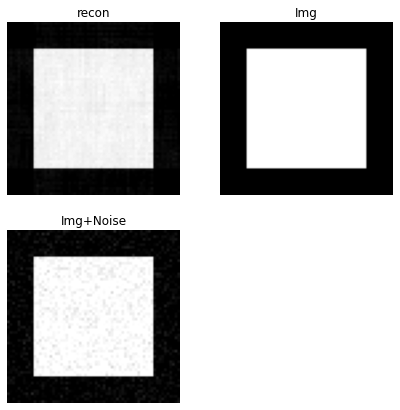

ending time in: 11.887 mins


In [12]:
Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = recon(noisy, clean, gpu=True , alpha=0.001, iterations=100000) 

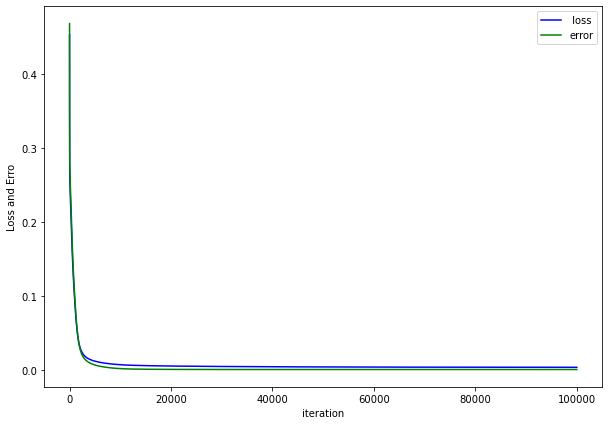

In [13]:
plt.figure(figsize=(10, 7)) #90 itr.
plt.plot(Loss, color='blue', label=' loss')
plt.plot(Error, color='green', label='error')
#plt.title('alpha=0') ###### early stopping
#plt.title('alpha=0.001')
plt.xlabel('iteration')
plt.ylabel('Loss and Erro')
plt.legend()
#plt.savefig('/content/drive/My Drive/psnr.png')
plt.show()

Text(0.5, 1.0, 'Plot of singular values')

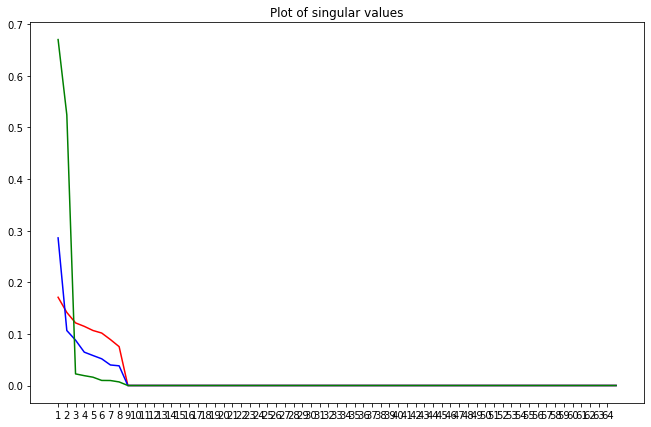

In [14]:
  plt.figure(figsize= (11,7))

  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "red" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[500], "blue" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "green" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  #plt.yscale("log")
  plt.title("Plot of singular values")

Text(0.5, 1.0, 'singular values')

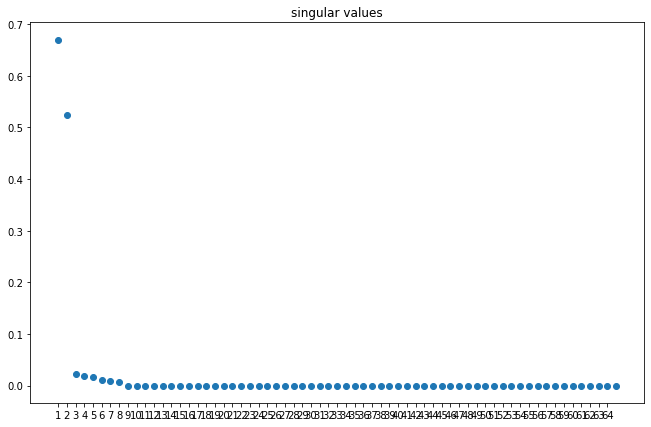

In [15]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "o" )
plt.xticks(np.arange(1, len(S_values[0] + 1)))
#plt.yscale("log")
plt.title("singular values")

Text(0.5, 1.0, 'singular values')

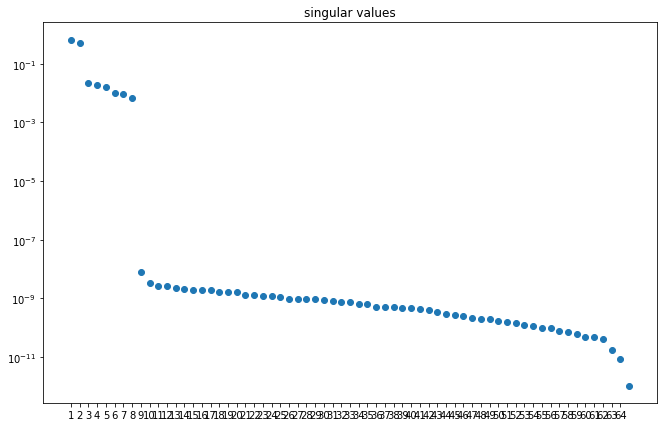

In [16]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "o" ) ####100,000 itr.!!!!
plt.xticks(np.arange(1, len(S_values[0] + 1)))
plt.yscale("log")
plt.title("singular values")

In [17]:
kernel=UV_outer[99000].cpu().detach()

In [18]:
kernel

tensor([[-0.0133, -0.0216, -0.0237,  ..., -0.0047,  0.0052, -0.0097],
        [-0.0098, -0.0191, -0.0210,  ..., -0.0005,  0.0092, -0.0061],
        [-0.0111, -0.0202, -0.0221,  ..., -0.0021,  0.0078, -0.0074],
        ...,
        [-0.0177, -0.0266, -0.0284,  ..., -0.0079,  0.0021, -0.0134],
        [-0.0151, -0.0251, -0.0264,  ..., -0.0056,  0.0043, -0.0113],
        [-0.0112, -0.0206, -0.0224,  ..., -0.0028,  0.0075, -0.0079]])

In [19]:
_,Sigma,_=torch.svd_lowrank(kernel, q=8, niter=2, M=None)

Text(0.5, 1.0, 'singular values')

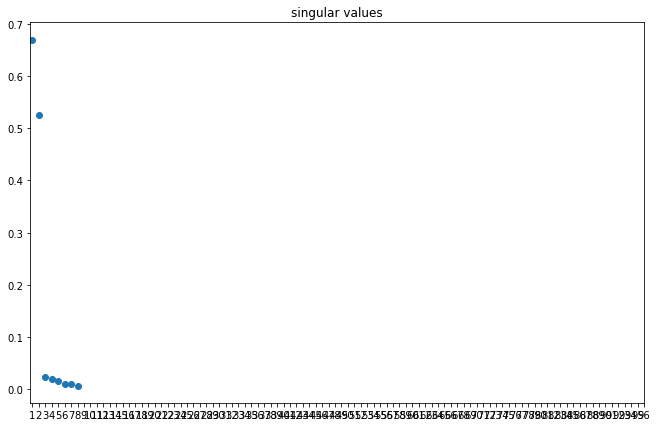

In [20]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(Sigma) + 1),Sigma, "o" )
plt.xticks(np.arange(1, 97))
#plt.yscale("log")
plt.title("singular values")

In [21]:
rec_f=Recons[99000].cpu().detach()

In [22]:
rec_f.shape

torch.Size([1, 1, 65, 65])

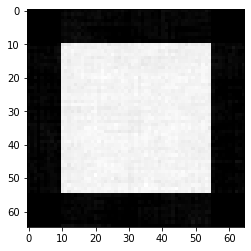

In [23]:
plt.imshow(rec_f[0][0], cmap="gray")

In [24]:
U, s, V = np.linalg.svd(rec_f[0][0], full_matrices=False)

Text(0.5, 1.0, 'singular values')

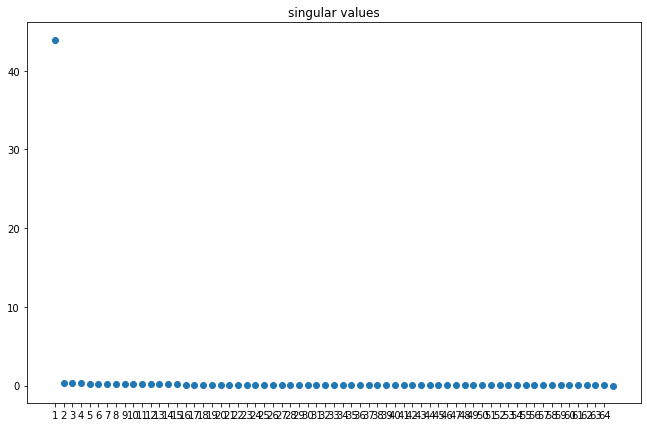

In [25]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 65))
#plt.yscale("log")
plt.title("singular values")

In [26]:
UV_outer

[tensor([[ 0.0039, -0.0075,  0.0110,  ...,  0.0051,  0.0017, -0.0004],
         [ 0.0073,  0.0004,  0.0054,  ..., -0.0070,  0.0033, -0.0002],
         [ 0.0089, -0.0037, -0.0025,  ...,  0.0110, -0.0021, -0.0067],
         ...,
         [ 0.0015,  0.0040,  0.0015,  ..., -0.0103,  0.0046, -0.0027],
         [ 0.0007,  0.0016,  0.0015,  ..., -0.0070,  0.0023, -0.0014],
         [ 0.0013,  0.0036,  0.0003,  ..., -0.0036,  0.0078,  0.0011]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[ 0.0038, -0.0076,  0.0110,  ...,  0.0050,  0.0016, -0.0005],
         [ 0.0074,  0.0005,  0.0056,  ..., -0.0070,  0.0034, -0.0002],
         [ 0.0089, -0.0037, -0.0026,  ...,  0.0109, -0.0021, -0.0068],
         ...,
         [ 0.0016,  0.0041,  0.0016,  ..., -0.0102,  0.0048, -0.0026],
         [ 0.0008,  0.0017,  0.0016,  ..., -0.0069,  0.0024, -0.0013],
         [ 0.0012,  0.0035,  0.0002,  ..., -0.0037,  0.0078,  0.0010]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[ 3.7431e

In [27]:
UV_kernel=UV_outer[99000].cpu().detach()

In [28]:
UV_kernel.shape

torch.Size([65, 65])

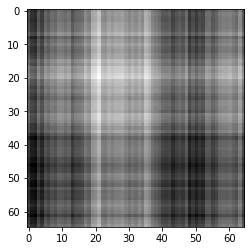

In [29]:
plt.imshow(UV_kernel, cmap="gray")

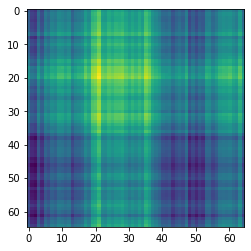

In [30]:
plt.imshow(UV_kernel)

In [31]:
U, s, V = np.linalg.svd(UV_kernel, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

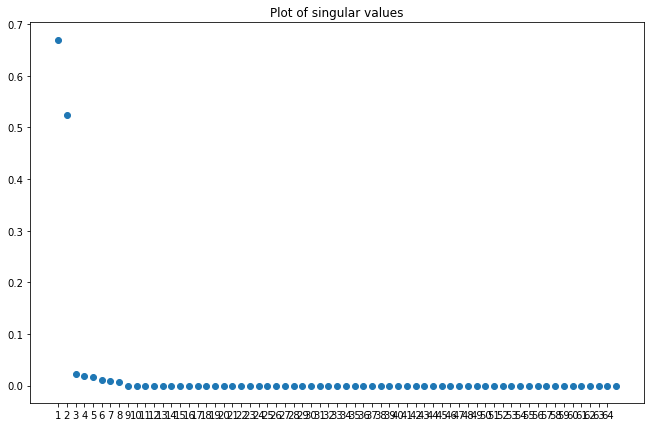

In [32]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 65))
#plt.yscale("log")
plt.title("Plot of singular values")

In [33]:
UV_kernel=np.array(UV_kernel)

In [34]:
UV_kernel.shape

(65, 65)

In [35]:
UV_kernel_transformed= np.fft.fft2(UV_kernel, axes=[0,1])

In [36]:
U, s, V = np.linalg.svd(UV_kernel_transformed, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

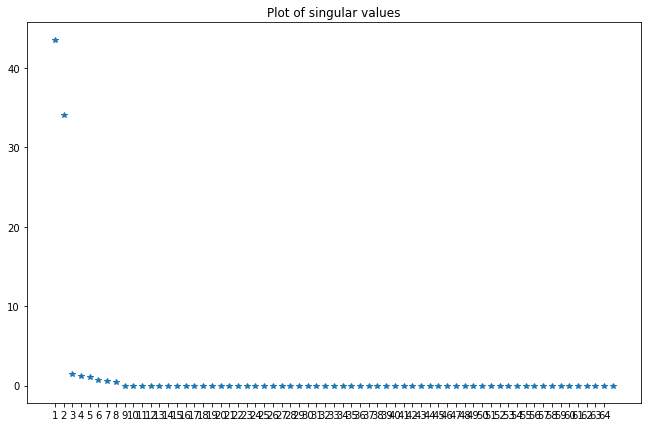

In [37]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "*" )
plt.xticks(np.arange(1, 65))
#plt.yscale("log")
plt.title("Plot of singular values")

In [38]:
U, s, V = np.linalg.svd(noisyImg, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

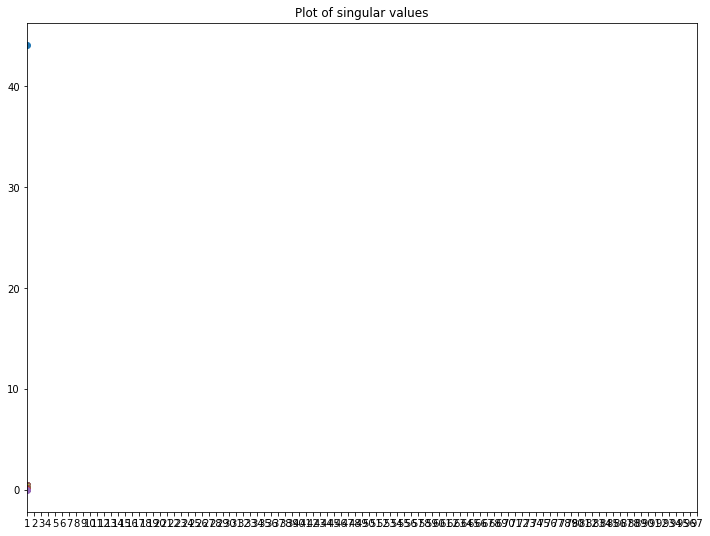

In [39]:
plt.figure(figsize= (12,9))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("Plot of singular values")

In [40]:
Nuc

[0.91204166,
 0.9122212,
 0.9124801,
 0.91287297,
 0.91350734,
 0.9145771,
 0.91631156,
 0.91859215,
 0.9205763,
 0.92145,
 0.92111975,
 0.91994655,
 0.91829294,
 0.9163939,
 0.91437614,
 0.9123127,
 0.91022795,
 0.90813714,
 0.9060514,
 0.9039751,
 0.9019084,
 0.89985263,
 0.89781034,
 0.89577997,
 0.8937632,
 0.8917576,
 0.8897635,
 0.88778317,
 0.88581324,
 0.883857,
 0.88191366,
 0.87997746,
 0.8780457,
 0.8761173,
 0.8741993,
 0.8722874,
 0.8703865,
 0.86849284,
 0.8666097,
 0.86473316,
 0.862865,
 0.86100924,
 0.8591633,
 0.857327,
 0.85550445,
 0.8536904,
 0.85188806,
 0.85009235,
 0.8483071,
 0.8465344,
 0.8447719,
 0.84301996,
 0.8412814,
 0.83955216,
 0.8378331,
 0.83612645,
 0.8344306,
 0.83274525,
 0.8310708,
 0.8294059,
 0.8277544,
 0.82611144,
 0.8244802,
 0.8228595,
 0.8212488,
 0.819649,
 0.81806105,
 0.81648177,
 0.81491363,
 0.813356,
 0.8118074,
 0.8102714,
 0.80874467,
 0.8072275,
 0.8057213,
 0.804225,
 0.8027387,
 0.8012629,
 0.7997972,
 0.79834056,
 0.7968936,
 0

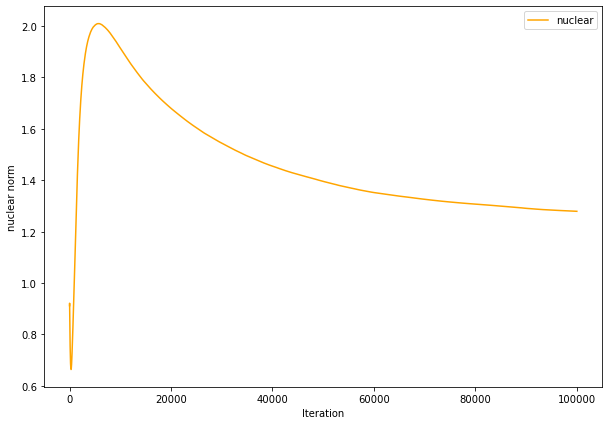

In [41]:
## nuclear norm
plt.figure(figsize=(10, 7))
plt.plot(Nuc, color='orange', label='nuclear')
#plt.title('alpha=0.1')
plt.xlabel('Iteration')
plt.ylabel('nuclear norm')
plt.legend()
#plt.savefig('/content/drive/My Drive/nuc.png')
plt.show()

In [42]:
norm2

[tensor(2.9164, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9167, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9171, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9176, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9185, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9199, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9219, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9245, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9268, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9278, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9273, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9258, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9236, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9212, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9186, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9159, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9132, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9105

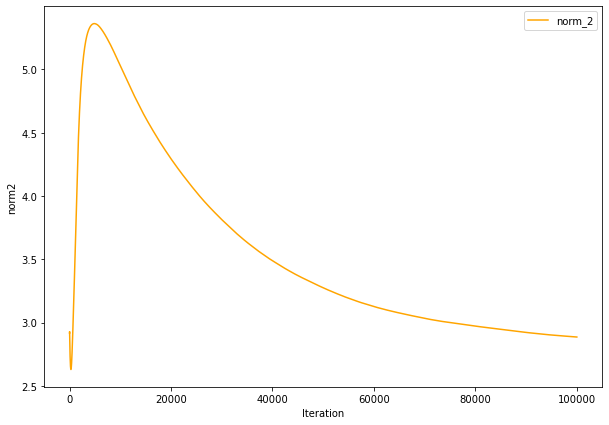

In [43]:
## 2 norm
plt.figure(figsize=(10, 7))
plt.plot(norm2, color='orange', label='norm_2')
#plt.title('alpha=0.1')
plt.xlabel('Iteration')
plt.ylabel('norm2')
plt.legend()
#plt.savefig('/content/drive/My Drive/nuc.png')
plt.show()